In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=32, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=32*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 14):
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 512000)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                8192016   
Total params: 8,192,208
Trainable params: 8,192,208
Non-trainable params: 0
___________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_22 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 8000, 32)          5152      
_________________________________________________________________
activation_23 (Activation)   (None, 8000, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 8000, 32)          5152      
_________________________________________________________________
activation_47 (Activation)   (None, 8000, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_66 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 8000, 32)          5152      
_________________________________________________________________
activation_68 (Activation)   (None, 8000, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3125 - acc: 0.2724
Epoch 00001: val_loss improved from inf to 1.96813, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_3_conv_checkpoint/001-1.9681.hdf5
36805/36805 [==============================] - 30s 821us/sample - loss: 2.3121 - acc: 0.2726 - val_loss: 1.9681 - val_acc: 0.4074
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7869 - acc: 0.4601
Epoch 00002: val_loss improved from 1.96813 to 1.75116, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_3_conv_checkpoint/002-1.7512.hdf5
36805/36805 [==============================] - 27s 742us/sample - loss: 1.7871 - acc: 0.4601 - val_loss: 1.7512 - val_acc: 0.4621
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5564 - acc: 0.5336
Epoch 00003: val_loss improved from 1.75116 to 1.6535

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1828 - acc: 0.9461
Epoch 00028: val_loss did not improve from 1.63493
36805/36805 [==============================] - 26s 710us/sample - loss: 0.1828 - acc: 0.9461 - val_loss: 2.6942 - val_acc: 0.4878
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1700 - acc: 0.9494
Epoch 00029: val_loss did not improve from 1.63493
36805/36805 [==============================] - 26s 712us/sample - loss: 0.1700 - acc: 0.9494 - val_loss: 2.7029 - val_acc: 0.5059
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1667 - acc: 0.9519
Epoch 00030: val_loss did not improve from 1.63493
36805/36805 [==============================] - 26s 711us/sample - loss: 0.1667 - acc: 0.9519 - val_loss: 2.7966 - val_acc: 0.4922
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1579 - acc: 0.9558
Epoch 00031: val_loss did not improve from 1.63493
36805/36805 [=====

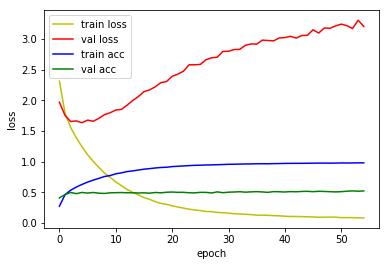

4815/4815 [==============================] - 2s 359us/sample - loss: 1.7100 - acc: 0.4746
Loss: 1.7099558357385336 Accuracy: 0.47455868

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3103 - acc: 0.2720
Epoch 00001: val_loss improved from inf to 1.91819, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_4_conv_checkpoint/001-1.9182.hdf5
36805/36805 [==============================] - 30s 822us/sample - loss: 2.3104 - acc: 0.2720 - val_loss: 1.9182 - val_acc: 0.4249
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7257 - acc: 0.4714
Epoch 00002: val_loss improved from 1.91819 to 1.56205, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_4_conv_checkpoint/002-1.5621.hdf5
36805/36805 [==============================] - 29s 778us/sample - loss: 1.7257 - acc: 0.4714 - val_loss: 1.5621 - val_acc: 0.5236
Epoch 3/500
36736/36805 [============================>.] - E

Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2662 - acc: 0.9153
Epoch 00028: val_loss did not improve from 1.33626
36805/36805 [==============================] - 29s 777us/sample - loss: 0.2663 - acc: 0.9152 - val_loss: 1.8045 - val_acc: 0.6091
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2553 - acc: 0.9188
Epoch 00029: val_loss did not improve from 1.33626
36805/36805 [==============================] - 28s 756us/sample - loss: 0.2551 - acc: 0.9189 - val_loss: 1.8500 - val_acc: 0.6084
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2493 - acc: 0.9206
Epoch 00030: val_loss did not improve from 1.33626
36805/36805 [==============================] - 28s 767us/sample - loss: 0.2494 - acc: 0.9206 - val_loss: 1.8553 - val_acc: 0.6070
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2432 - acc: 0.9225
Epoch 00031: val_loss did not improve from 1.33626
36805/36805 [=====

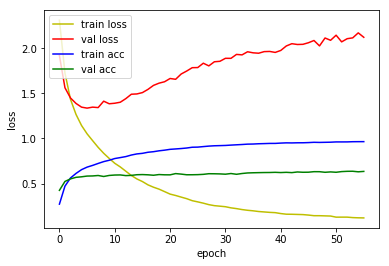

4815/4815 [==============================] - 2s 369us/sample - loss: 1.4001 - acc: 0.5664
Loss: 1.4001398931287408 Accuracy: 0.56635517

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2341 - acc: 0.2849
Epoch 00001: val_loss improved from inf to 1.68214, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_5_conv_checkpoint/001-1.6821.hdf5
36805/36805 [==============================] - 33s 905us/sample - loss: 2.2340 - acc: 0.2849 - val_loss: 1.6821 - val_acc: 0.4701
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5087 - acc: 0.5274
Epoch 00002: val_loss improved from 1.68214 to 1.36156, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_5_conv_checkpoint/002-1.3616.hdf5
36805/36805 [==============================] - 31s 839us/sample - loss: 1.5087 - acc: 0.5274 - val_loss: 1.3616 - val_acc: 0.5851
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1533 - acc: 0.9541
Epoch 00028: val_loss did not improve from 1.16856
36805/36805 [==============================] - 31s 840us/sample - loss: 0.1533 - acc: 0.9541 - val_loss: 1.5522 - val_acc: 0.6785
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1418 - acc: 0.9562
Epoch 00029: val_loss did not improve from 1.16856
36805/36805 [==============================] - 31s 837us/sample - loss: 0.1418 - acc: 0.9562 - val_loss: 1.5944 - val_acc: 0.6811
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1359 - acc: 0.9573
Epoch 00030: val_loss did not improve from 1.16856
36805/36805 [==============================] - 31s 837us/sample - loss: 0.1358 - acc: 0.9573 - val_loss: 1.6240 - val_acc: 0.6853
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1311 - acc: 0.9602
Epoch 00031: val_loss did not improve from 1.16856
36805/36805 [=====


1D_CNN_custom_pool_2_ch_32_DO_5_conv Model


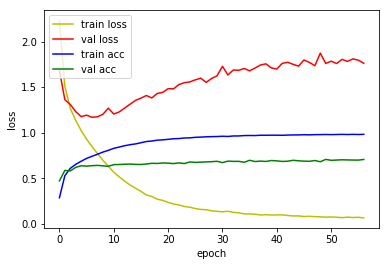

4815/4815 [==============================] - 2s 405us/sample - loss: 1.2685 - acc: 0.6147
Loss: 1.2684546218359087 Accuracy: 0.61474556

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1048 - acc: 0.3253
Epoch 00001: val_loss improved from inf to 1.58550, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_6_conv_checkpoint/001-1.5855.hdf5
36805/36805 [==============================] - 35s 959us/sample - loss: 2.1048 - acc: 0.3253 - val_loss: 1.5855 - val_acc: 0.5043
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5341 - acc: 0.5070
Epoch 00002: val_loss improved from 1.58550 to 1.40019, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_6_conv_checkpoint/002-1.4002.hdf5
36805/36805 [==============================] - 33s 886us/sample - loss: 1.5341 - acc: 0.5070 - val_loss: 1.4002 - val_acc: 0.5563
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2698 - acc: 0.9125
Epoch 00027: val_loss did not improve from 0.94256
36805/36805 [==============================] - 33s 884us/sample - loss: 0.2698 - acc: 0.9125 - val_loss: 1.0981 - val_acc: 0.7258
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2561 - acc: 0.9168
Epoch 00028: val_loss did not improve from 0.94256
36805/36805 [==============================] - 32s 881us/sample - loss: 0.2561 - acc: 0.9169 - val_loss: 1.0392 - val_acc: 0.7356
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2415 - acc: 0.9216
Epoch 00029: val_loss did not improve from 0.94256
36805/36805 [==============================] - 32s 882us/sample - loss: 0.2415 - acc: 0.9216 - val_loss: 1.1322 - val_acc: 0.7305
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2297 - acc: 0.9265
Epoch 00030: val_loss did not improve from 0.94256
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9661
Epoch 00057: val_loss did not improve from 0.94256
36805/36805 [==============================] - 33s 885us/sample - loss: 0.1088 - acc: 0.9661 - val_loss: 1.1920 - val_acc: 0.7675
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1093 - acc: 0.9663
Epoch 00058: val_loss did not improve from 0.94256
36805/36805 [==============================] - 32s 881us/sample - loss: 0.1093 - acc: 0.9663 - val_loss: 1.2358 - val_acc: 0.7647
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1062 - acc: 0.9676
Epoch 00059: val_loss did not improve from 0.94256
36805/36805 [==============================] - 32s 881us/sample - loss: 0.1062 - acc: 0.9676 - val_loss: 1.2034 - val_acc: 0.7738
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1011 - acc: 0.9705
Epoch 00060: val_loss did not improve from 0.94256
36805/36805 [=====

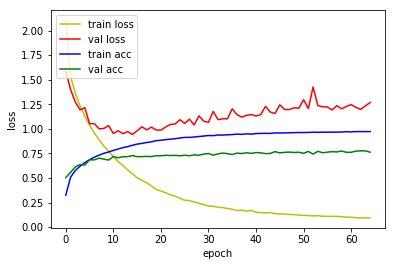

4815/4815 [==============================] - 2s 427us/sample - loss: 1.0257 - acc: 0.6993
Loss: 1.025704760950055 Accuracy: 0.6992731

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2545 - acc: 0.2699
Epoch 00001: val_loss improved from inf to 1.62630, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_7_conv_checkpoint/001-1.6263.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 2.2543 - acc: 0.2700 - val_loss: 1.6263 - val_acc: 0.4759
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5802 - acc: 0.4937
Epoch 00002: val_loss improved from 1.62630 to 1.43795, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_7_conv_checkpoint/002-1.4380.hdf5
36805/36805 [==============================] - 33s 905us/sample - loss: 1.5802 - acc: 0.4937 - val_loss: 1.4380 - val_acc: 0.5514
Epoch 3/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.4419 - acc: 0.8624
Epoch 00023: val_loss did not improve from 0.69585
36805/36805 [==============================] - 33s 904us/sample - loss: 0.4419 - acc: 0.8624 - val_loss: 0.7300 - val_acc: 0.7869
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4168 - acc: 0.8714
Epoch 00024: val_loss did not improve from 0.69585
36805/36805 [==============================] - 33s 904us/sample - loss: 0.4168 - acc: 0.8714 - val_loss: 0.8138 - val_acc: 0.7817
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3973 - acc: 0.8759
Epoch 00025: val_loss did not improve from 0.69585
36805/36805 [==============================] - 33s 906us/sample - loss: 0.3973 - acc: 0.8759 - val_loss: 0.7051 - val_acc: 0.7987
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3785 - acc: 0.8803
Epoch 00026: val_loss did not improve from 0.69585
36805/36805 [==================

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1587 - acc: 0.9484
Epoch 00053: val_loss did not improve from 0.69585
36805/36805 [==============================] - 33s 904us/sample - loss: 0.1587 - acc: 0.9483 - val_loss: 0.7862 - val_acc: 0.8251
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1506 - acc: 0.9503
Epoch 00054: val_loss did not improve from 0.69585
36805/36805 [==============================] - 33s 903us/sample - loss: 0.1506 - acc: 0.9503 - val_loss: 0.8024 - val_acc: 0.8251
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1477 - acc: 0.9525
Epoch 00055: val_loss did not improve from 0.69585
36805/36805 [==============================] - 33s 898us/sample - loss: 0.1477 - acc: 0.9525 - val_loss: 0.8297 - val_acc: 0.8246
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1457 - acc: 0.9534
Epoch 00056: val_loss did not improve from 0.69585
36805/36805 [=====

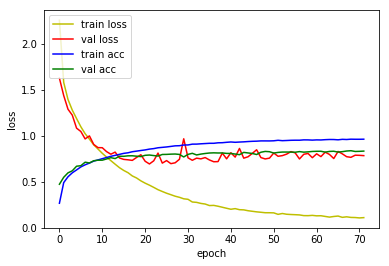

4815/4815 [==============================] - 2s 448us/sample - loss: 0.7964 - acc: 0.7670
Loss: 0.7964310067217422 Accuracy: 0.7669782

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4209 - acc: 0.2016
Epoch 00001: val_loss improved from inf to 1.75422, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_8_conv_checkpoint/001-1.7542.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 2.4209 - acc: 0.2016 - val_loss: 1.7542 - val_acc: 0.4580
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6265 - acc: 0.4757
Epoch 00002: val_loss improved from 1.75422 to 1.40381, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_8_conv_checkpoint/002-1.4038.hdf5
36805/36805 [==============================] - 34s 915us/sample - loss: 1.6265 - acc: 0.4757 - val_loss: 1.4038 - val_acc: 0.5535
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4034 - acc: 0.8790
Epoch 00023: val_loss did not improve from 0.46833
36805/36805 [==============================] - 34s 914us/sample - loss: 0.4034 - acc: 0.8790 - val_loss: 0.4926 - val_acc: 0.8654
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3885 - acc: 0.8842
Epoch 00024: val_loss improved from 0.46833 to 0.43424, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_8_conv_checkpoint/024-0.4342.hdf5
36805/36805 [==============================] - 34s 917us/sample - loss: 0.3885 - acc: 0.8842 - val_loss: 0.4342 - val_acc: 0.8866
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3733 - acc: 0.8855
Epoch 00025: val_loss did not improve from 0.43424
36805/36805 [==============================] - 33s 910us/sample - loss: 0.3732 - acc: 0.8855 - val_loss: 0.4575 - val_acc: 0.8826
Epoch 26/500
36800/36805 [============================>.] - ETA:

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1818 - acc: 0.9413
Epoch 00050: val_loss did not improve from 0.38740
36805/36805 [==============================] - 34s 915us/sample - loss: 0.1817 - acc: 0.9413 - val_loss: 0.4599 - val_acc: 0.8977
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1809 - acc: 0.9411
Epoch 00051: val_loss did not improve from 0.38740
36805/36805 [==============================] - 34s 913us/sample - loss: 0.1809 - acc: 0.9411 - val_loss: 0.4137 - val_acc: 0.9054
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1773 - acc: 0.9427
Epoch 00052: val_loss did not improve from 0.38740
36805/36805 [==============================] - 34s 914us/sample - loss: 0.1773 - acc: 0.9427 - val_loss: 0.4124 - val_acc: 0.9047
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1750 - acc: 0.9435
Epoch 00053: val_loss did not improve from 0.38740
36805/36805 [=====

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9637
Epoch 00080: val_loss did not improve from 0.38740
36805/36805 [==============================] - 33s 908us/sample - loss: 0.1106 - acc: 0.9637 - val_loss: 0.4318 - val_acc: 0.9022
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1130 - acc: 0.9631
Epoch 00081: val_loss did not improve from 0.38740
36805/36805 [==============================] - 33s 909us/sample - loss: 0.1129 - acc: 0.9631 - val_loss: 0.4298 - val_acc: 0.9108
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1107 - acc: 0.9641
Epoch 00082: val_loss did not improve from 0.38740
36805/36805 [==============================] - 34s 914us/sample - loss: 0.1107 - acc: 0.9641 - val_loss: 0.4357 - val_acc: 0.9073
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1005 - acc: 0.9670
Epoch 00083: val_loss did not improve from 0.38740
36805/36805 [=====

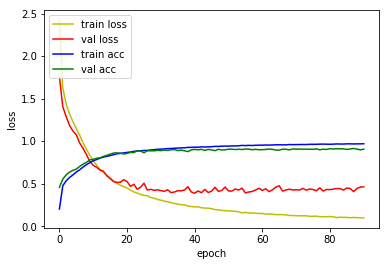

4815/4815 [==============================] - 2s 489us/sample - loss: 0.4819 - acc: 0.8685
Loss: 0.48190565458339324 Accuracy: 0.8685358

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3981 - acc: 0.2076
Epoch 00001: val_loss improved from inf to 1.73749, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_9_conv_checkpoint/001-1.7375.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 2.3980 - acc: 0.2076 - val_loss: 1.7375 - val_acc: 0.4489
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6180 - acc: 0.4743
Epoch 00002: val_loss improved from 1.73749 to 1.33921, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_9_conv_checkpoint/002-1.3392.hdf5
36805/36805 [==============================] - 35s 951us/sample - loss: 1.6179 - acc: 0.4743 - val_loss: 1.3392 - val_acc: 0.5879
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 0.2936 - acc: 0.9082
Epoch 00023: val_loss improved from 0.34172 to 0.31105, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_9_conv_checkpoint/023-0.3110.hdf5
36805/36805 [==============================] - 35s 948us/sample - loss: 0.2936 - acc: 0.9082 - val_loss: 0.3110 - val_acc: 0.9143
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2826 - acc: 0.9115
Epoch 00024: val_loss did not improve from 0.31105
36805/36805 [==============================] - 35s 947us/sample - loss: 0.2826 - acc: 0.9116 - val_loss: 0.3276 - val_acc: 0.9080
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2698 - acc: 0.9136
Epoch 00025: val_loss did not improve from 0.31105
36805/36805 [==============================] - 35s 945us/sample - loss: 0.2698 - acc: 0.9135 - val_loss: 0.3135 - val_acc: 0.9143
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9595
Epoch 00050: val_loss did not improve from 0.26799
36805/36805 [==============================] - 35s 946us/sample - loss: 0.1229 - acc: 0.9595 - val_loss: 0.2837 - val_acc: 0.9313
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1174 - acc: 0.9614
Epoch 00051: val_loss did not improve from 0.26799
36805/36805 [==============================] - 35s 948us/sample - loss: 0.1174 - acc: 0.9614 - val_loss: 0.2870 - val_acc: 0.9357
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1209 - acc: 0.9601
Epoch 00052: val_loss did not improve from 0.26799
36805/36805 [==============================] - 35s 947us/sample - loss: 0.1209 - acc: 0.9601 - val_loss: 0.2915 - val_acc: 0.9341
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1120 - acc: 0.9628
Epoch 00053: val_loss did not improve from 0.26799
36805/36805 [==================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0669 - acc: 0.9774
Epoch 00080: val_loss did not improve from 0.26799
36805/36805 [==============================] - 35s 949us/sample - loss: 0.0669 - acc: 0.9774 - val_loss: 0.3124 - val_acc: 0.9369
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0646 - acc: 0.9780
Epoch 00081: val_loss did not improve from 0.26799
36805/36805 [==============================] - 35s 947us/sample - loss: 0.0646 - acc: 0.9780 - val_loss: 0.3309 - val_acc: 0.9406
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0711 - acc: 0.9776
Epoch 00082: val_loss did not improve from 0.26799
36805/36805 [==============================] - 35s 949us/sample - loss: 0.0711 - acc: 0.9776 - val_loss: 0.3246 - val_acc: 0.9373
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0696 - acc: 0.9762
Epoch 00083: val_loss did not improve from 0.26799
36805/36805 [=====

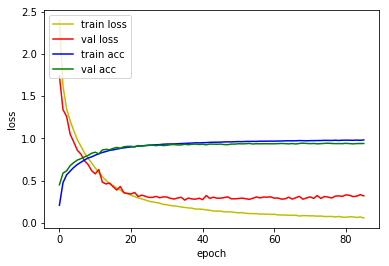

4815/4815 [==============================] - 2s 504us/sample - loss: 0.3154 - acc: 0.9074
Loss: 0.3154498406597882 Accuracy: 0.9073728

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4767 - acc: 0.1797
Epoch 00001: val_loss improved from inf to 1.82376, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_10_conv_checkpoint/001-1.8238.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 2.4766 - acc: 0.1797 - val_loss: 1.8238 - val_acc: 0.4253
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6122 - acc: 0.4672
Epoch 00002: val_loss improved from 1.82376 to 1.27557, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_10_conv_checkpoint/002-1.2756.hdf5
36805/36805 [==============================] - 35s 962us/sample - loss: 1.6123 - acc: 0.4672 - val_loss: 1.2756 - val_acc: 0.6052
Epoch 3/500
36800/36805 [============================>.] - ET

36800/36805 [============================>.] - ETA: 0s - loss: 0.2742 - acc: 0.9128
Epoch 00023: val_loss did not improve from 0.26596
36805/36805 [==============================] - 35s 963us/sample - loss: 0.2742 - acc: 0.9128 - val_loss: 0.2681 - val_acc: 0.9241
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2616 - acc: 0.9145
Epoch 00024: val_loss improved from 0.26596 to 0.25548, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_10_conv_checkpoint/024-0.2555.hdf5
36805/36805 [==============================] - 36s 966us/sample - loss: 0.2616 - acc: 0.9145 - val_loss: 0.2555 - val_acc: 0.9283
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2494 - acc: 0.9197
Epoch 00025: val_loss improved from 0.25548 to 0.25529, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_10_conv_checkpoint/025-0.2553.hdf5
36805/36805 [==============================] - 35s 962us/sample - loss: 0.2495 - acc: 0.9197 - val_loss

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1172 - acc: 0.9618
Epoch 00049: val_loss did not improve from 0.18030
36805/36805 [==============================] - 35s 946us/sample - loss: 0.1172 - acc: 0.9618 - val_loss: 0.1905 - val_acc: 0.9543
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1130 - acc: 0.9626
Epoch 00050: val_loss did not improve from 0.18030
36805/36805 [==============================] - 35s 951us/sample - loss: 0.1130 - acc: 0.9626 - val_loss: 0.1877 - val_acc: 0.9513
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1107 - acc: 0.9635
Epoch 00051: val_loss did not improve from 0.18030
36805/36805 [==============================] - 35s 960us/sample - loss: 0.1107 - acc: 0.9635 - val_loss: 0.1902 - val_acc: 0.9515
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1065 - acc: 0.9651
Epoch 00052: val_loss did not improve from 0.18030
36805/36805 [=====

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0644 - acc: 0.9790
Epoch 00078: val_loss did not improve from 0.17810
36805/36805 [==============================] - 35s 958us/sample - loss: 0.0645 - acc: 0.9790 - val_loss: 0.1844 - val_acc: 0.9567
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0715 - acc: 0.9765
Epoch 00079: val_loss did not improve from 0.17810
36805/36805 [==============================] - 35s 948us/sample - loss: 0.0715 - acc: 0.9765 - val_loss: 0.1931 - val_acc: 0.9576
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0600 - acc: 0.9796
Epoch 00080: val_loss did not improve from 0.17810
36805/36805 [==============================] - 35s 954us/sample - loss: 0.0599 - acc: 0.9796 - val_loss: 0.2116 - val_acc: 0.9539
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0600 - acc: 0.9794
Epoch 00081: val_loss did not improve from 0.17810
36805/36805 [=====

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9846
Epoch 00108: val_loss did not improve from 0.17810
36805/36805 [==============================] - 35s 957us/sample - loss: 0.0444 - acc: 0.9846 - val_loss: 0.2212 - val_acc: 0.9534
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9853
Epoch 00109: val_loss did not improve from 0.17810
36805/36805 [==============================] - 35s 954us/sample - loss: 0.0444 - acc: 0.9853 - val_loss: 0.2211 - val_acc: 0.9553
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9862
Epoch 00110: val_loss did not improve from 0.17810
36805/36805 [==============================] - 35s 957us/sample - loss: 0.0411 - acc: 0.9862 - val_loss: 0.2283 - val_acc: 0.9564
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9866
Epoch 00111: val_loss did not improve from 0.17810
36805/36805 [=

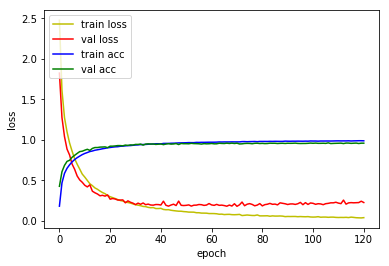

4815/4815 [==============================] - 3s 535us/sample - loss: 0.2060 - acc: 0.9481
Loss: 0.20598556604449128 Accuracy: 0.94807893

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4368 - acc: 0.1965
Epoch 00001: val_loss improved from inf to 1.84902, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_11_conv_checkpoint/001-1.8490.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.4368 - acc: 0.1965 - val_loss: 1.8490 - val_acc: 0.4123
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5392 - acc: 0.4940
Epoch 00002: val_loss improved from 1.84902 to 1.09299, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_11_conv_checkpoint/002-1.0930.hdf5
36805/36805 [==============================] - 36s 969us/sample - loss: 1.5392 - acc: 0.4940 - val_loss: 1.0930 - val_acc: 0.6452
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2188 - acc: 0.9281
Epoch 00023: val_loss did not improve from 0.17754
36805/36805 [==============================] - 36s 975us/sample - loss: 0.2189 - acc: 0.9281 - val_loss: 0.1839 - val_acc: 0.9457
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2160 - acc: 0.9299
Epoch 00024: val_loss did not improve from 0.17754
36805/36805 [==============================] - 36s 972us/sample - loss: 0.2160 - acc: 0.9300 - val_loss: 0.1798 - val_acc: 0.9439
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1978 - acc: 0.9353
Epoch 00025: val_loss did not improve from 0.17754
36805/36805 [==============================] - 36s 972us/sample - loss: 0.1978 - acc: 0.9353 - val_loss: 0.1889 - val_acc: 0.9455
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1956 - acc: 0.9356
Epoch 00026: val_loss improved from 0.17754 to 0.16521, saving model 

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9699
Epoch 00050: val_loss did not improve from 0.12985
36805/36805 [==============================] - 36s 972us/sample - loss: 0.0891 - acc: 0.9699 - val_loss: 0.1369 - val_acc: 0.9630
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0869 - acc: 0.9699
Epoch 00051: val_loss did not improve from 0.12985
36805/36805 [==============================] - 36s 971us/sample - loss: 0.0870 - acc: 0.9699 - val_loss: 0.1812 - val_acc: 0.9520
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0902 - acc: 0.9687
Epoch 00052: val_loss did not improve from 0.12985
36805/36805 [==============================] - 36s 967us/sample - loss: 0.0902 - acc: 0.9687 - val_loss: 0.1319 - val_acc: 0.9637
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0880 - acc: 0.9705
Epoch 00053: val_loss did not improve from 0.12985
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9839
Epoch 00079: val_loss did not improve from 0.12762
36805/36805 [==============================] - 36s 970us/sample - loss: 0.0469 - acc: 0.9839 - val_loss: 0.1303 - val_acc: 0.9658
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9814
Epoch 00080: val_loss did not improve from 0.12762
36805/36805 [==============================] - 36s 971us/sample - loss: 0.0514 - acc: 0.9814 - val_loss: 0.1527 - val_acc: 0.9644
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9843
Epoch 00081: val_loss did not improve from 0.12762
36805/36805 [==============================] - 36s 973us/sample - loss: 0.0464 - acc: 0.9843 - val_loss: 0.1514 - val_acc: 0.9658
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9846
Epoch 00082: val_loss did not improve from 0.12762
36805/36805 [==================

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9891
Epoch 00109: val_loss did not improve from 0.12762
36805/36805 [==============================] - 35s 956us/sample - loss: 0.0327 - acc: 0.9891 - val_loss: 0.1738 - val_acc: 0.9627
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9888
Epoch 00110: val_loss did not improve from 0.12762
36805/36805 [==============================] - 35s 957us/sample - loss: 0.0329 - acc: 0.9888 - val_loss: 0.1682 - val_acc: 0.9637
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9893
Epoch 00111: val_loss did not improve from 0.12762
36805/36805 [==============================] - 36s 975us/sample - loss: 0.0326 - acc: 0.9893 - val_loss: 0.1582 - val_acc: 0.9683
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9889
Epoch 00112: val_loss did not improve from 0.12762
36805/36805 [=

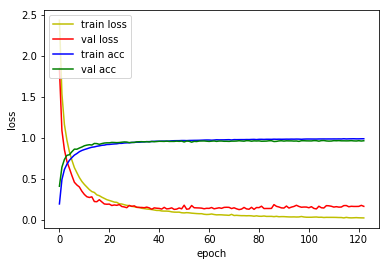

4815/4815 [==============================] - 3s 557us/sample - loss: 0.1737 - acc: 0.9564
Loss: 0.17369112051860938 Accuracy: 0.95638627

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4245 - acc: 0.2062
Epoch 00001: val_loss improved from inf to 1.77950, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_12_conv_checkpoint/001-1.7795.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.4244 - acc: 0.2062 - val_loss: 1.7795 - val_acc: 0.4437
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5480 - acc: 0.4955
Epoch 00002: val_loss improved from 1.77950 to 1.12665, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_12_conv_checkpoint/002-1.1266.hdf5
36805/36805 [==============================] - 37s 995us/sample - loss: 1.5480 - acc: 0.4955 - val_loss: 1.1266 - val_acc: 0.6331
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2150 - acc: 0.9287
Epoch 00023: val_loss improved from 0.17830 to 0.17178, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_12_conv_checkpoint/023-0.1718.hdf5
36805/36805 [==============================] - 37s 996us/sample - loss: 0.2150 - acc: 0.9287 - val_loss: 0.1718 - val_acc: 0.9471
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1925 - acc: 0.9377
Epoch 00024: val_loss improved from 0.17178 to 0.16277, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_12_conv_checkpoint/024-0.1628.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.1925 - acc: 0.9376 - val_loss: 0.1628 - val_acc: 0.9502
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1856 - acc: 0.9400
Epoch 00025: val_loss did not improve from 0.16277
36805/36805 [==============================] - 37s 998us/sample - loss: 0.1856 - acc: 0.9400

36800/36805 [============================>.] - ETA: 0s - loss: 0.0724 - acc: 0.9758
Epoch 00050: val_loss did not improve from 0.12700
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0725 - acc: 0.9758 - val_loss: 0.1532 - val_acc: 0.9613
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0692 - acc: 0.9766
Epoch 00051: val_loss did not improve from 0.12700
36805/36805 [==============================] - 37s 998us/sample - loss: 0.0692 - acc: 0.9766 - val_loss: 0.1511 - val_acc: 0.9613
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0732 - acc: 0.9748
Epoch 00052: val_loss did not improve from 0.12700
36805/36805 [==============================] - 37s 1000us/sample - loss: 0.0732 - acc: 0.9748 - val_loss: 0.1376 - val_acc: 0.9644
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9757
Epoch 00053: val_loss did not improve from 0.12700
36805/36805 [===================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9865
Epoch 00080: val_loss did not improve from 0.12700
36805/36805 [==============================] - 37s 997us/sample - loss: 0.0410 - acc: 0.9866 - val_loss: 0.1510 - val_acc: 0.9672
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9882
Epoch 00081: val_loss did not improve from 0.12700
36805/36805 [==============================] - 37s 1000us/sample - loss: 0.0360 - acc: 0.9882 - val_loss: 0.1737 - val_acc: 0.9611
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9880
Epoch 00082: val_loss did not improve from 0.12700
36805/36805 [==============================] - 37s 997us/sample - loss: 0.0359 - acc: 0.9880 - val_loss: 0.1837 - val_acc: 0.9606
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9878
Epoch 00083: val_loss did not improve from 0.12700
36805/36805 [====

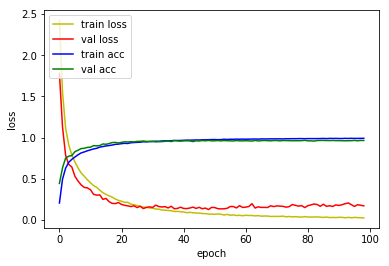

4815/4815 [==============================] - 3s 579us/sample - loss: 0.2029 - acc: 0.9481
Loss: 0.20288274491347008 Accuracy: 0.94807893

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2981 - acc: 0.2566
Epoch 00001: val_loss improved from inf to 1.67576, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_13_conv_checkpoint/001-1.6758.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.2981 - acc: 0.2566 - val_loss: 1.6758 - val_acc: 0.4635
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4578 - acc: 0.5254
Epoch 00002: val_loss improved from 1.67576 to 0.97453, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_13_conv_checkpoint/002-0.9745.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.4578 - acc: 0.5254 - val_loss: 0.9745 - val_acc: 0.6809
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1446 - acc: 0.9507
Epoch 00024: val_loss improved from 0.16160 to 0.15128, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_13_conv_checkpoint/024-0.1513.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1445 - acc: 0.9507 - val_loss: 0.1513 - val_acc: 0.9536
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1331 - acc: 0.9558
Epoch 00025: val_loss did not improve from 0.15128
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1331 - acc: 0.9558 - val_loss: 0.1671 - val_acc: 0.9469
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1290 - acc: 0.9567
Epoch 00026: val_loss improved from 0.15128 to 0.13859, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_13_conv_checkpoint/026-0.1386.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1290 - acc: 0.9567 - v

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0468 - acc: 0.9847
Epoch 00053: val_loss did not improve from 0.13859
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0469 - acc: 0.9847 - val_loss: 0.1614 - val_acc: 0.9604
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9863
Epoch 00054: val_loss did not improve from 0.13859
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0420 - acc: 0.9863 - val_loss: 0.1660 - val_acc: 0.9609
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9867
Epoch 00055: val_loss did not improve from 0.13859
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0388 - acc: 0.9867 - val_loss: 0.2010 - val_acc: 0.9564
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9869
Epoch 00056: val_loss did not improve from 0.13859
36805/36805 [===========

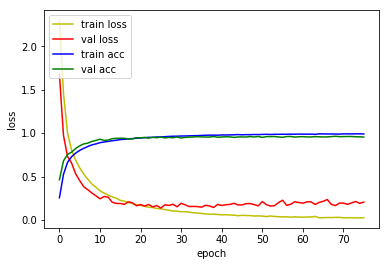

4815/4815 [==============================] - 3s 591us/sample - loss: 0.2342 - acc: 0.9315
Loss: 0.23419579769468257 Accuracy: 0.9314642



In [10]:
for i in range(3, 14):
    base = '1D_CNN_custom_pool_2_ch_32_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_pool_2_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 14):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

    log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_pool_2_ch_32_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_91 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_92 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 8000, 32)          5152      
_________________________________________________________________
activation_93 (Activation)   (No

4815/4815 [==============================] - 3s 572us/sample - loss: 1.0257 - acc: 0.6993
Loss: 1.025704760950055 Accuracy: 0.6992731

1D_CNN_custom_pool_2_ch_32_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_109 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
activation_109 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_110 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_92 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_111 (Conv1D)          (

4815/4815 [==============================] - 3s 649us/sample - loss: 0.3154 - acc: 0.9074
Loss: 0.3154498406597882 Accuracy: 0.9073728

1D_CNN_custom_pool_2_ch_32_DO_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_133 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
activation_133 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
activation_134 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_113 (MaxPoolin (None, 8000, 32)          0         
_________________________________________________________________
conv1d_135 (Conv1D)         

4815/4815 [==============================] - 3s 691us/sample - loss: 0.1737 - acc: 0.9564
Loss: 0.17369112051860938 Accuracy: 0.95638627

1D_CNN_custom_pool_2_ch_32_DO_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_154 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
activation_154 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
activation_155 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_132 (MaxPoolin (None, 8000, 32)          0         
_________________________________________________________________
conv1d_156 (Conv1D)       

4815/4815 [==============================] - 3s 700us/sample - loss: 0.2342 - acc: 0.9315
Loss: 0.23419579769468257 Accuracy: 0.9314642


In [12]:
for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_pool_2_ch_32_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_91 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_92 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 8000, 32)          5152      
_________________________________________________________________
activation_93 (Activation)   (No

4815/4815 [==============================] - 3s 695us/sample - loss: 1.4751 - acc: 0.7294
Loss: 1.4751127770385266 Accuracy: 0.72938734

1D_CNN_custom_pool_2_ch_32_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_109 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
activation_109 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_110 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_92 (MaxPooling (None, 8000, 32)          0         
_________________________________________________________________
conv1d_111 (Conv1D)         

4815/4815 [==============================] - 4s 779us/sample - loss: 0.3348 - acc: 0.9238
Loss: 0.3347622621282239 Accuracy: 0.92377985

1D_CNN_custom_pool_2_ch_32_DO_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_133 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
activation_133 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
activation_134 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_113 (MaxPoolin (None, 8000, 32)          0         
_________________________________________________________________
conv1d_135 (Conv1D)        

4815/4815 [==============================] - 4s 768us/sample - loss: 0.2365 - acc: 0.9537
Loss: 0.2364583510686092 Accuracy: 0.9536864

1D_CNN_custom_pool_2_ch_32_DO_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_154 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
activation_154 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
activation_155 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_132 (MaxPoolin (None, 8000, 32)          0         
_________________________________________________________________
conv1d_156 (Conv1D)         

4815/4815 [==============================] - 4s 820us/sample - loss: 0.3230 - acc: 0.9364
Loss: 0.32301166008244947 Accuracy: 0.9364486
